# QLearning Time-Difference Method

#### Imports

In [73]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import numpy as np
from abc import ABC, abstractmethod
import pandas as pd

### Environment


In [74]:
class PowerMarket(ABC):
    '''
    Power Market abstract base class
    '''
    def __init__(self, scale, nplayers=1, a=10, b=1, c = [0.01], max_episodes=1, initial_state=[1.]):
        self.max_episodes = max_episodes
        self.scale = scale
        self.nplayers = nplayers
        self.cost = c
        self.a = a
        self.b = b
        self.episode = 0                
        self.initial_state = np.atleast_1d(initial_state)
        self.state = self.initial_state
        self.state_size = self.initial_state.shape[0]
    
    def reset(self):
        self.episode = 0
        return self.initial_state
        
    def step(self, actions):
        # Cournot price equilibrium
        new_state, rewards = self.solver(actions)        
        self.state = new_state
        self.episode += 1
        if self.episode>=self.max_episodes:
            done=True
        else:
            done=False
        return new_state, np.array(rewards), done, []
    
    @abstractmethod
    def solver(self, actions):
        pass
    
    
class RL1(PowerMarket):
    def solver(self, actions):
        Q = sum(actions)/self.scale
        price = np.max([0,self.a - self.b*Q])
        #price = self.a - self.b*Q
        rewards = [(price-c)*a/self.scale for c,a in zip(self.cost,actions)]
        return np.atleast_1d(price), rewards
           
        

### Q-Learning Agent

In [75]:
def discount_rewards(r, gamma):
    """ 
    Compute discounted reward 
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

class QAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(QAgent,self).__init__('q_agent')
        # These lines establish the feed-forward part of the network used to estimate Q(s, a)
        # state = slim.one_hot_encoding(self.state_input, num_states)
        self.q_out = layers.Dense(num_actions, use_bias = False, kernel_initializer= 'zeros', activation='linear')
        
    def call(self, state):
        return self.q_out(state)

    def choose_action(self, state):
        q = self(state)
        a = tf.argmax(q,1)
        return a, q
               

### Hyperparamters

In [114]:
np.set_printoptions(precision=2)

y = .99 # Discount rate
start_e = 1 # Starting epsilon value
end_e = 0.1 # Final epsilon value
annealing_steps = 1000 # Number of steps to anneal epsilon
num_episodes = 100000 # Total episodes to run environment
learning_rate = 1e-2 # Agent learning rate

nplayers = 3
nactions = 101
a = 10
b = 1
c = [0.,0.,0.]# [0.0,0.1,0.2]
scale = (nactions-1)/a*b

optimizer = optimizers.Adam(learning_rate=learning_rate)
lossfun = losses.MeanSquaredError()

### Training

In [115]:
agent = [QAgent(nactions) for i in range(nplayers)]
[a.compile(optimizer=optimizer, loss=lossfun) for a in agent]    

e_drop = (start_e - end_e) / annealing_steps
e = start_e    
value_table = np.zeros((nplayers, env.state_size))

# Create lists to contain total rewards and steps per episode
episode_list = []
reward_list = [[]]*nplayers
loss_list = [[]]*nplayers
for i in range(num_episodes):
    state = env.reset().astype('float32')[None,:]
    total_reward = [0]*nplayers
    done = False
    steps = 0
    while not done:
        steps +=1
        # Choose an action by greedily (with e chance of random action) from the Q-network
        action,Q = [],[]
        for a in agent:
            a, q = a.choose_action(state)
            a = a[0]
            if np.random.rand(1) < e:
                a = np.random.randint(0, nactions)            
            action.append(a)
            Q.append(q)

        # Get new state and reward from environment
        state_1, reward, done, _ = env.step(np.atleast_1d(action))
        state_1 = state_1.astype('float32')[None,:]
        
        for i in range(len(agent)):
            targetQ = Q[i]
            if not done:
                Q1 = agent[i](state_1)
                maxQ1 = np.max(Q1)
                targetQ[0, action] = reward + y*maxQ1
            else:
                targetQ = Q[i].numpy()
                targetQ[0, action] = reward

            # Train our network using target and estimated Q values
            loss = agent[i].train_on_batch(state, targetQ)
            q_table = agent[i](state)
            total_reward[i] += reward
            value_table[i] = np.mean(q_table, axis=1)
            loss_list[i].append(loss)
            
        state = state_1
        if e > end_e:
            e -= e_drop
        
    episode_list.append(steps)
    reward_list.append(total_reward)
    if i % 100 == 0 and i != 0:
        print ("Mean Reward: {}".format(np.mean(reward_list[-100:])))


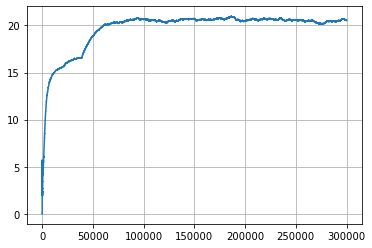

In [123]:
r = pd.DataFrame(np.concatenate(reward_list[3:],axis=0))
r.sum(axis=1).ewm(halflife=10000).mean().plot()
plt.grid()